In [ ]:
"""
Mount Google Colab Notebook correctly so we are in the correct relative directory
"""
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"3. Experiments"/"3. COVID_Forecaster"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/3. Experiments/3. COVID_Forecaster


In [ ]:
###################################################################################################################################
"""
Ensure we have correct version of Pytorch Geometric before importing or installing anything else
"""
# Code in this cell is courtesy of: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7 
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch
import os

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install torch-geometric-temporal # added for GConvGRU
!pip install ogb

print("PyTorch has version {}".format(torch.__version__))

########################################################################################################################################

"""
Download and Import any other libraries we will use later on
"""

! pip install epiweeks
! pip install haversine

import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch.nn import Linear
from torch_geometric.nn import GCNConv 
from torch_geometric_temporal.nn.recurrent import GConvGRU
# from preprocess_data import get_preprocessed_data

##############################################################################################################################################


Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
PyTorch has version 1.10.0+cu111


In [ ]:
"""
Declare global variables
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
inputLayer_num_features = 24
hiddenLayer1_num_features = 24
hiddenLayer2_num_features = 24
outputLayer_num_features = 15 # pred_window, redeclared from preprocessing_data
chebyshev_filter_size = 2
history_window = 6 # history_window, redeclared from preprocessing_data 
preprocessed_data_relative_file_path = 'data/preprocessed_data_v3.3_to_3.5_new_data.pickle'
save_model_relative_path = './saved_models/v3.4_new_data_COVID_Forecaster_no_skip_connections'
numEpochs = 1000
save_predictions_relative_path = './saved_models/v3.4_archived_output.pickle'

cpu


In [ ]:
# Try to ensure reproducibility
torch.manual_seed(0)

In [ ]:
"""
Get and unpack preprocessed data
"""

# # Get preprocessed data and unpackage variables needed during training/testing/validation
# preprocessed_data = get_preprocessed_data()
# # Save preprocessed data as pickle so we don't have to consecutively re-download the same data (time consuming) when re-running all cells in this notebook
# with open(preprocessed_data_relative_file_path, 'wb') as handle:
#     pickle.dump(preprocessed_data, handle)


# Load in saved preprocessed_data
preprocessed_data = None
with open(preprocessed_data_relative_file_path, 'rb') as handle:
    preprocessed_data = pickle.load(handle)

# Unpack preprocessed data
training_variables = preprocessed_data['training_variables']
validation_variables = preprocessed_data['validation_variables']
testing_variables = preprocessed_data['testing_variables']

edge_index = preprocessed_data['edge_index']

train_x = training_variables['train_x_smoothed']
train_y = training_variables['train_y_confirmed_smoothed']

val_x = validation_variables['val_x_smoothed']
val_y = validation_variables['val_y_confirmed_unsmoothed']

test_x = testing_variables['test_x_smoothed']
test_y = testing_variables['test_y_confirmed_unsmoothed']

In [ ]:
"""
Put preprocessed data into "Data" objects and put "Data" objects into tensors on the "device"
"""
training_data = []
validation_data = []
testing_data = []
for i in range(len(train_x)):
  toAppend = Data(x=train_x[i], y=train_y[i], edge_index=edge_index).to(device)
  training_data.append(toAppend)
for i in range(len(val_x)):
  toAppend = Data(x=val_x[i], y=val_y[i], edge_index=edge_index).to(device)
  validation_data.append(toAppend)
for i in range(len(test_x)):
  toAppend = Data(x=test_x[i], y=test_y[i], edge_index=edge_index).to(device)
  testing_data.append(toAppend)

In [ ]:
"""
Define network architecture, optimizer, and loss function
Reference: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html 
"""

class COVID_forecaster_no_skip(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = GConvGRU(in_channels=inputLayer_num_features, out_channels=hiddenLayer1_num_features, K=chebyshev_filter_size)
      self.conv2 = GConvGRU(in_channels=hiddenLayer1_num_features, out_channels=hiddenLayer2_num_features, K=chebyshev_filter_size)
      self.linear1 = Linear(hiddenLayer2_num_features, outputLayer_num_features)
      # self.linear2 = Linear(history_window, outputLayer_num_features)
      self.linear3 = Linear(outputLayer_num_features, outputLayer_num_features)

    def forward(self, data):
      x, edge_index = data.x, data.edge_index
      x = self.conv1(x, edge_index)
      x = F.elu(x)
      x = self.conv2(x, edge_index)
      x = F.elu(x)
      x = self.linear1(x) # + self.linear2(data.x[:, 0:history_window])

      x = F.elu(x)
      x = self.linear3(x)

      return x

model = COVID_forecaster_no_skip().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.MSELoss()

In [ ]:
model

COVID_forecaster_no_skip(
  (conv1): GConvGRU(
    (conv_x_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (conv2): GConvGRU(
    (conv_x_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (linear1): Linear(in_features=24, out_features=15, bias=True)
  (linear3): Linear(in_features=15, out_features=15, bias=True)
)

In [ ]:
"""
Training
"""
min_loss = 1e20

def train():
  total_loss = 0.0
  for data in training_data:
    model.train()
    optimizer.zero_grad()
    predicted_output = model(data)
    labeled_output = data.y.to(device)
    loss = criterion(predicted_output, labeled_output)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
  return total_loss

def validation():
  model.eval()
  totalLoss = 0.0
  for data_validation in validation_data:
    validation_prediction_output = model(data_validation)
    labeled_validation_output = data_validation.y.to(device)
    loss = criterion(validation_prediction_output, labeled_validation_output)
    totalLoss += loss.item()
  return totalLoss

for epoch in range(numEpochs):
  training_loss = train()
  val_loss = validation()
  if val_loss < min_loss:
    min_loss = val_loss
    state = {
        'state': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, save_model_relative_path)
    print("==================================================================")
    print("Saved best model")
  print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, training_loss, val_loss))

Saved best model
Epoch 0, Loss 94081830569472.00, Val loss 4626484559872.00
Saved best model
Epoch 1, Loss 93959255288064.00, Val loss 4622414512128.00
Saved best model
Epoch 2, Loss 93732288338432.00, Val loss 4615775977472.00
Saved best model
Epoch 3, Loss 93401604307712.00, Val loss 4606657560576.00
Saved best model
Epoch 4, Loss 92973555450624.00, Val loss 4595206586368.00
Saved best model
Epoch 5, Loss 92456056790528.00, Val loss 4581585059840.00
Saved best model
Epoch 6, Loss 91857582640896.00, Val loss 4565962326016.00
Saved best model
Epoch 7, Loss 91186612429312.00, Val loss 4548506157056.00
Saved best model
Epoch 8, Loss 90451253819136.00, Val loss 4529371217920.00
Saved best model
Epoch 9, Loss 89659996851968.00, Val loss 4508718989312.00
Saved best model
Epoch 10, Loss 88820686750464.00, Val loss 4486716719104.00
Saved best model
Epoch 11, Loss 87940348560640.00, Val loss 4463486042112.00
Saved best model
Epoch 12, Loss 87025176204544.00, Val loss 4439160651776.00
Saved bes

2431431737344.0
tensor([13463.0586, 13508.6543, 13549.7822, 13589.4062, 13630.3613, 13674.8369,
        13720.2861, 13765.4502, 13813.0449, 13870.2744, 13908.8525, 13954.3213,
        14002.5654, 14055.3535, 14102.5186], grad_fn=<SelectBackward0>)
tensor([292187., 293697., 293697., 293697., 293697., 293697., 295701., 296870.,
        297729., 297729., 297729., 298362., 298626., 298808., 298993.])


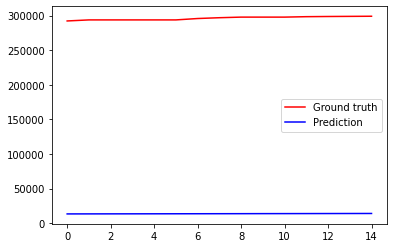

In [ ]:
"""
Testing and plotting results
"""

predicted_output = None
labeled_output = None
for data in testing_data:
  model.eval()
  predicted_output = model(data)
  labeled_output = data.y.to(device)
  loss = criterion(predicted_output, labeled_output)
  print(loss.item())

state_num = 29

print(predicted_output[state_num])
print(labeled_output[state_num])

plt.plot(labeled_output[state_num].cpu().detach().numpy(),c='r', label='Ground truth')
plt.plot(predicted_output[state_num].cpu().detach().numpy(),c='b', label='Prediction')
plt.legend()
plt.show()

In [ ]:
archived_output = {
    # 'loc_list':loc_list, 
    # 'model_predictions_number_infected_dictionary':model_predictions_number_infected_dictionary, 
    'model_predictions_cumulative_infected_tensor':predicted_output, # (52, 15)
    # 'ground_truth_number_infected_dictionary':ground_truth_number_infected_dictionary, 
    'ground_truth_cumulative_infected_tensor':labeled_output # (52, 15)
}
# Save archived_output as pickle for use later
with open(save_predictions_relative_path, 'wb') as handle:
    pickle.dump(archived_output, handle)


# # Load in archived_output pickle
# archived_output = None
# with open(save_predictions_relative_path, 'rb') as handle:
#     archived_output = pickle.load(handle)

In [ ]:
mean_squared_error = criterion(predicted_output.reshape((52, 15)), labeled_output.reshape((52, 15))).item()
mae_function = torch.nn.L1Loss()
mean_absolute_error = mae_function(predicted_output.reshape((52, 15)), labeled_output.reshape((52, 15))).item()
print("mean squared error: ", mean_squared_error)
print("mean absolute error: ", mean_absolute_error)

# With seed = 0 - trial 1
# mean squared error:  2431431737344.0
# mean absolute error:  978706.625

# With seed = 0 - trial 2
# mean squared error:  2431431737344.0
# mean absolute error:  978706.625

mean squared error:  2431431737344.0
mean absolute error:  978706.625
